In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import AveragePooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [ ]:
def normalize(image):            return (image/255 - 0.5)*2
def to_image(normalized_image):  return ((normalized_image/2 + 0.5) * 255).astype(np.uint8)

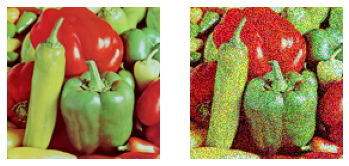

In [ ]:
im = cv2.imread("peppers.png")[:,:,::-1]  #BGR to RGB
noise_intensity = 50
noise = np.random.randint(-noise_intensity, noise_intensity, size = im.shape)
im_noise = (im + noise).clip(0,255).astype(np.uint8)

plt.subplot(121); plt.axis('off'); plt.imshow(to_image(normalize(im)))
plt.subplot(122); plt.axis('off'); plt.imshow(im_noise)
plt.show()

In [ ]:
def deep_image_prior_model():
    encoding_size = 128

    encoder = Sequential([
        Convolution2D(32, 3, padding='same', input_shape=[128,128,3], activation='relu'),
        Convolution2D(32, 3, padding='same', activation='relu'),
        AveragePooling2D(),
        Convolution2D(64, 3, padding='same', activation='relu'),
        Convolution2D(64, 3, padding='same', activation='relu'),   
        AveragePooling2D(),
        Convolution2D(128, 3, padding='same', activation='relu'),
        Convolution2D(128, 3, padding='same', activation='relu'),
        Flatten(),
        Dense(encoding_size, activation='tanh')
    ])

    decoder = Sequential([
        Dense(192, input_shape=(encoding_size,), activation='relu'),
        Reshape((8, 8, 3)),
        Convolution2D(128, 3, padding='same', activation='relu'),
        Convolution2D(128, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(64, 3, padding='same', activation='relu'),
        Convolution2D(64, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(32, 3, padding='same', activation='relu'),
        Convolution2D(32, 3, padding='same', activation='relu'),
        UpSampling2D(),    
        Convolution2D(16, 3, padding='same', activation='relu'),
        Convolution2D(16, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(8, 3, padding='same', activation='relu'),
        Convolution2D(3, 3, padding='same', activation='tanh')
    ])


    autoencoder = Sequential([
        encoder, 
        decoder
    ])
    
    autoencoder.compile(loss='mse', optimizer=Adam(lr=0.0001))
    return autoencoder

In [ ]:
x = np.random.random(size=((1,) + im.shape)) * 2 - 1
y = normalize(im_noise[None, :])
[x.shape, y.shape]

[(1, 128, 128, 3), (1, 128, 128, 3)]

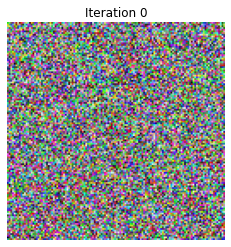

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


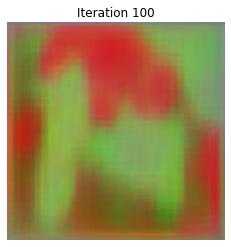

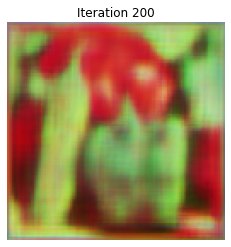

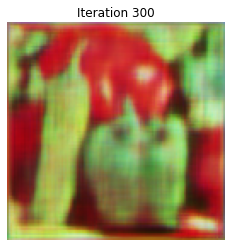

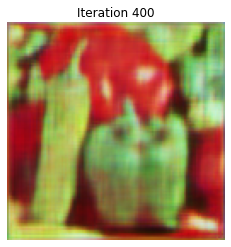

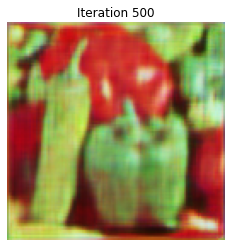

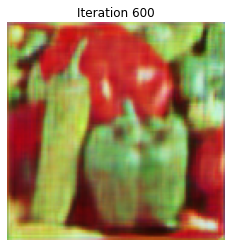

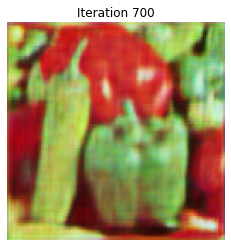

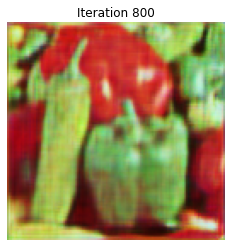

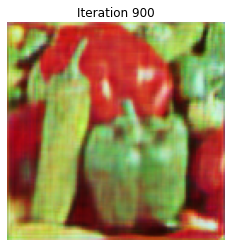

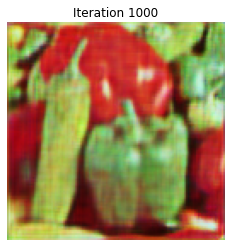

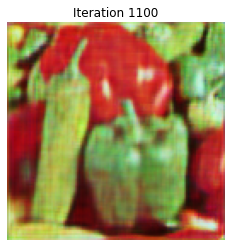

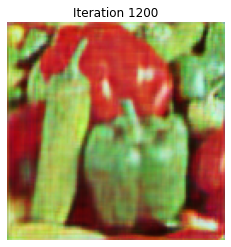

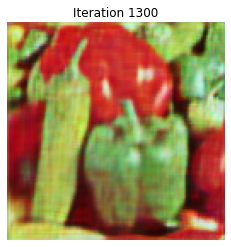

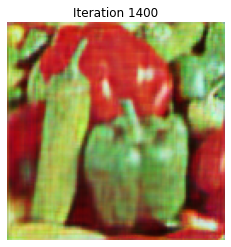

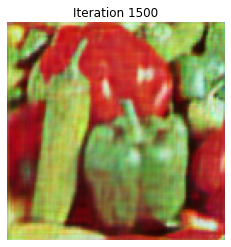

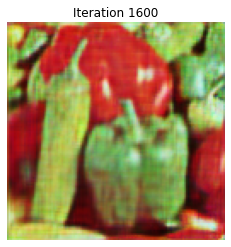

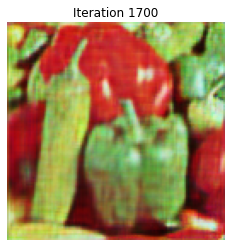

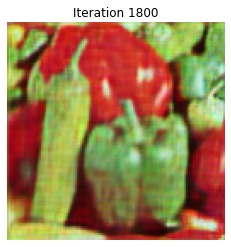

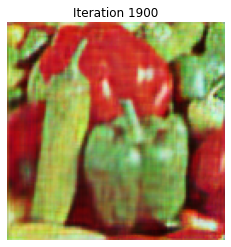

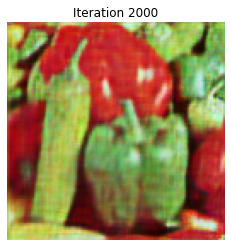

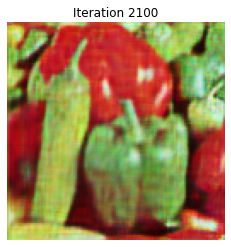

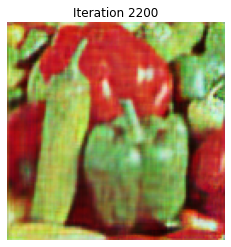

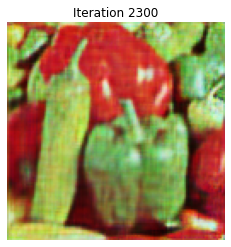

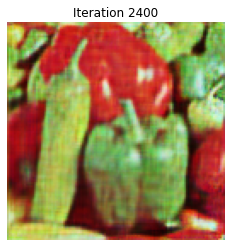

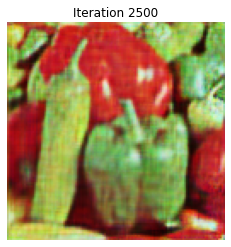

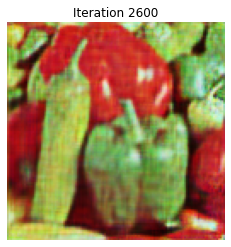

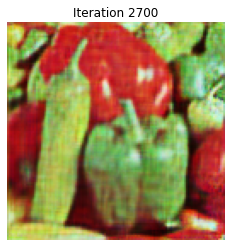

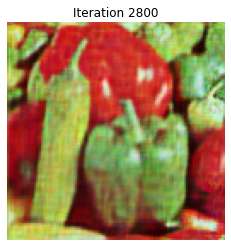

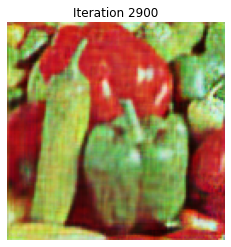

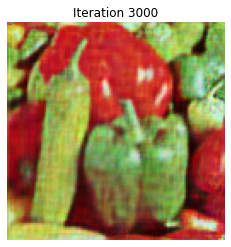

In [ ]:
plt.axis('off')
plt.title('Iteration 0')
plt.imshow(to_image(x[0]))
plt.show()

model = deep_image_prior_model()
iterations = 30                  # in hundreds
results = np.empty(x.shape)

for i in range(iterations):
    model.fit(x, y, epochs=100, batch_size=1, verbose=0)
    output = model.predict(x)
    results = np.append(results, output, axis=0)
    plt.axis('off')
    plt.title('Iteration '+ str((i+1)*100))
    plt.imshow(to_image(output[0]))
    plt.show()

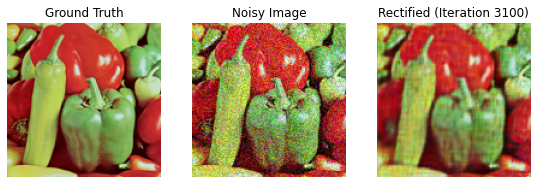

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(im)
plt.subplot(152); plt.axis('off'); plt.title('Noisy Image'); plt.imshow(im_noise)
# i=10; plt.subplot(153); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
# i=16; plt.subplot(154); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
i=30; plt.subplot(153); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
plt.show()